In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torchvision.models.vgg import vgg16_bn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pathlib import Path
import json
from tqdm import tqdm

In [2]:
# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR = 'feature_importance_results'
Path(SAVE_DIR).mkdir(exist_ok=True)

In [3]:
# Initialisation du modèle VGG16
model = vgg16_bn(pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/home/timotheewsl/PER/Guillaume/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/timotheewsl/PER/Guillaume/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Transformations
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# Chargement du dataset CIFAR-10 et sélection d'une image unique
cifar10 = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
cifar10_test = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform)
train_loader = DataLoader(cifar10, batch_size=32, shuffle=True)

Image de test de la classe : cat


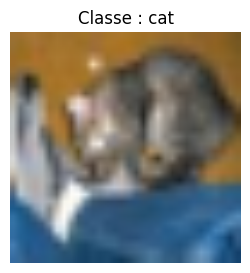

In [6]:
# Image de référence depuis le test set
test_img, test_label = cifar10_test[0]
test_img = test_img.unsqueeze(0).to(device)

# Classes CIFAR10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Image de test de la classe : {classes[test_label]}")

# Afficher l'image
plt.figure(figsize=(3,3))
img = test_img.squeeze().cpu().numpy()
img = np.transpose(img, (1,2,0))
# Dénormaliser l'image
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.title(f"Classe : {classes[test_label]}")
plt.axis('off')
plt.show()

In [7]:
def compute_feature_importance(model, input_tensor, layer_idx, allFeaturesIDX, pred_class):
    """Calcule l'importance globale des features"""
    with torch.no_grad():
        output_original = model(input_tensor)
        probs_original = torch.nn.functional.softmax(output_original, dim=1)
        original_score = probs_original[0, pred_class].item()

    def zero_out_features(module, input, output):
        for idx in allFeaturesIDX:
            output[:, idx, :, :] = 0
        return output

    hook = model.features[layer_idx].register_forward_hook(zero_out_features)
    
    with torch.no_grad():
        output_disabled = model(input_tensor)
        probs_disabled = torch.nn.functional.softmax(output_disabled, dim=1)
        new_score = probs_disabled[0, pred_class].item()

    hook.remove()
    importance = original_score - new_score
    print(f"Original score: {original_score:.4f}")
    print(f"New score: {new_score:.4f}")
    print(f"Importance: {importance:.4f}")
    return importance

In [8]:
# Entraînement et analyse
n_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

importances_history = []

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    
    # 1. Analyser l'importance des features
    model.eval()
    with torch.no_grad():
        output = model(test_img)
        test_label = torch.argmax(output, dim=1).item()
        
    print(f"Analyzing features for class {test_label}...")
    importances = []
    for feature_idx in range(512):
        importance = compute_feature_importance(model, test_img, 40, [feature_idx], test_label)
        importances.append(importance)
        
    importances_history.append(importances)
    
    # Afficher les 5 features les plus importantes
    top_indices = np.argsort(importances)[-5:]
    print("\nTop 5 features les plus importantes:")
    for idx in reversed(top_indices):
        print(f"Feature {idx}: {importances[idx]:.4f}")
    
    # 2. Entraînement
    model.train()
    for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Training epoch {epoch+1}")):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


Epoch 1/10
Analyzing features for class 335...
Original score: 0.0800
New score: 0.0810
Importance: -0.0010
Original score: 0.0800
New score: 0.0707
Importance: 0.0093
Original score: 0.0800
New score: 0.0702
Importance: 0.0098
Original score: 0.0800
New score: 0.0805
Importance: -0.0005
Original score: 0.0800
New score: 0.0800
Importance: 0.0000
Original score: 0.0800
New score: 0.0798
Importance: 0.0002
Original score: 0.0800
New score: 0.0842
Importance: -0.0042
Original score: 0.0800
New score: 0.0777
Importance: 0.0023
Original score: 0.0800
New score: 0.0799
Importance: 0.0001
Original score: 0.0800
New score: 0.0850
Importance: -0.0050
Original score: 0.0800
New score: 0.0713
Importance: 0.0087
Original score: 0.0800
New score: 0.0791
Importance: 0.0009
Original score: 0.0800
New score: 0.0817
Importance: -0.0017
Original score: 0.0800
New score: 0.0676
Importance: 0.0124
Original score: 0.0800
New score: 0.0852
Importance: -0.0052
Original score: 0.0800
New score: 0.1184
Impor

Training epoch 1: 100%|██████████| 1563/1563 [03:28<00:00,  7.50it/s]



Epoch 2/10
Analyzing features for class 3...
Original score: 0.9842
New score: 0.9840
Importance: 0.0002
Original score: 0.9842
New score: 0.9842
Importance: 0.0000
Original score: 0.9842
New score: 0.9809
Importance: 0.0032
Original score: 0.9842
New score: 0.9839
Importance: 0.0003
Original score: 0.9842
New score: 0.9842
Importance: 0.0000
Original score: 0.9842
New score: 0.9843
Importance: -0.0001
Original score: 0.9842
New score: 0.9842
Importance: 0.0000
Original score: 0.9842
New score: 0.9842
Importance: -0.0000
Original score: 0.9842
New score: 0.9842
Importance: 0.0000
Original score: 0.9842
New score: 0.9842
Importance: 0.0000
Original score: 0.9842
New score: 0.9846
Importance: -0.0004
Original score: 0.9842
New score: 0.9842
Importance: -0.0000
Original score: 0.9842
New score: 0.9842
Importance: 0.0000
Original score: 0.9842
New score: 0.9841
Importance: 0.0001
Original score: 0.9842
New score: 0.9842
Importance: 0.0000
Original score: 0.9842
New score: 0.9842
Importanc

Training epoch 2: 100%|██████████| 1563/1563 [03:27<00:00,  7.54it/s]



Epoch 3/10
Analyzing features for class 3...
Original score: 0.9941
New score: 0.9947
Importance: -0.0005
Original score: 0.9941
New score: 0.9942
Importance: -0.0001
Original score: 0.9941
New score: 0.9927
Importance: 0.0014
Original score: 0.9941
New score: 0.9941
Importance: 0.0000
Original score: 0.9941
New score: 0.9941
Importance: 0.0000
Original score: 0.9941
New score: 0.9941
Importance: 0.0000
Original score: 0.9941
New score: 0.9941
Importance: 0.0000
Original score: 0.9941
New score: 0.9941
Importance: -0.0000
Original score: 0.9941
New score: 0.9942
Importance: -0.0000
Original score: 0.9941
New score: 0.9942
Importance: -0.0000
Original score: 0.9941
New score: 0.9944
Importance: -0.0003
Original score: 0.9941
New score: 0.9941
Importance: 0.0000
Original score: 0.9941
New score: 0.9941
Importance: 0.0000
Original score: 0.9941
New score: 0.9943
Importance: -0.0002
Original score: 0.9941
New score: 0.9942
Importance: -0.0001
Original score: 0.9941
New score: 0.9941
Impor

Training epoch 3: 100%|██████████| 1563/1563 [03:23<00:00,  7.68it/s]



Epoch 4/10
Analyzing features for class 3...
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importan

Training epoch 4: 100%|██████████| 1563/1563 [03:29<00:00,  7.45it/s]



Epoch 5/10
Analyzing features for class 3...
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importanc

Training epoch 5: 100%|██████████| 1563/1563 [03:27<00:00,  7.52it/s]



Epoch 6/10
Analyzing features for class 3...
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0

Training epoch 6: 100%|██████████| 1563/1563 [03:29<00:00,  7.47it/s]



Epoch 7/10
Analyzing features for class 3...
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0

Training epoch 7: 100%|██████████| 1563/1563 [03:30<00:00,  7.43it/s]



Epoch 8/10
Analyzing features for class 3...
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 

Training epoch 8: 100%|██████████| 1563/1563 [03:27<00:00,  7.55it/s]



Epoch 9/10
Analyzing features for class 3...
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importan

Training epoch 9: 100%|██████████| 1563/1563 [03:29<00:00,  7.45it/s]



Epoch 10/10
Analyzing features for class 3...
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: -0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importance: 0.0000
Original score: 1.0000
New score: 1.0000
Importan

Training epoch 10: 100%|██████████| 1563/1563 [03:27<00:00,  7.52it/s]


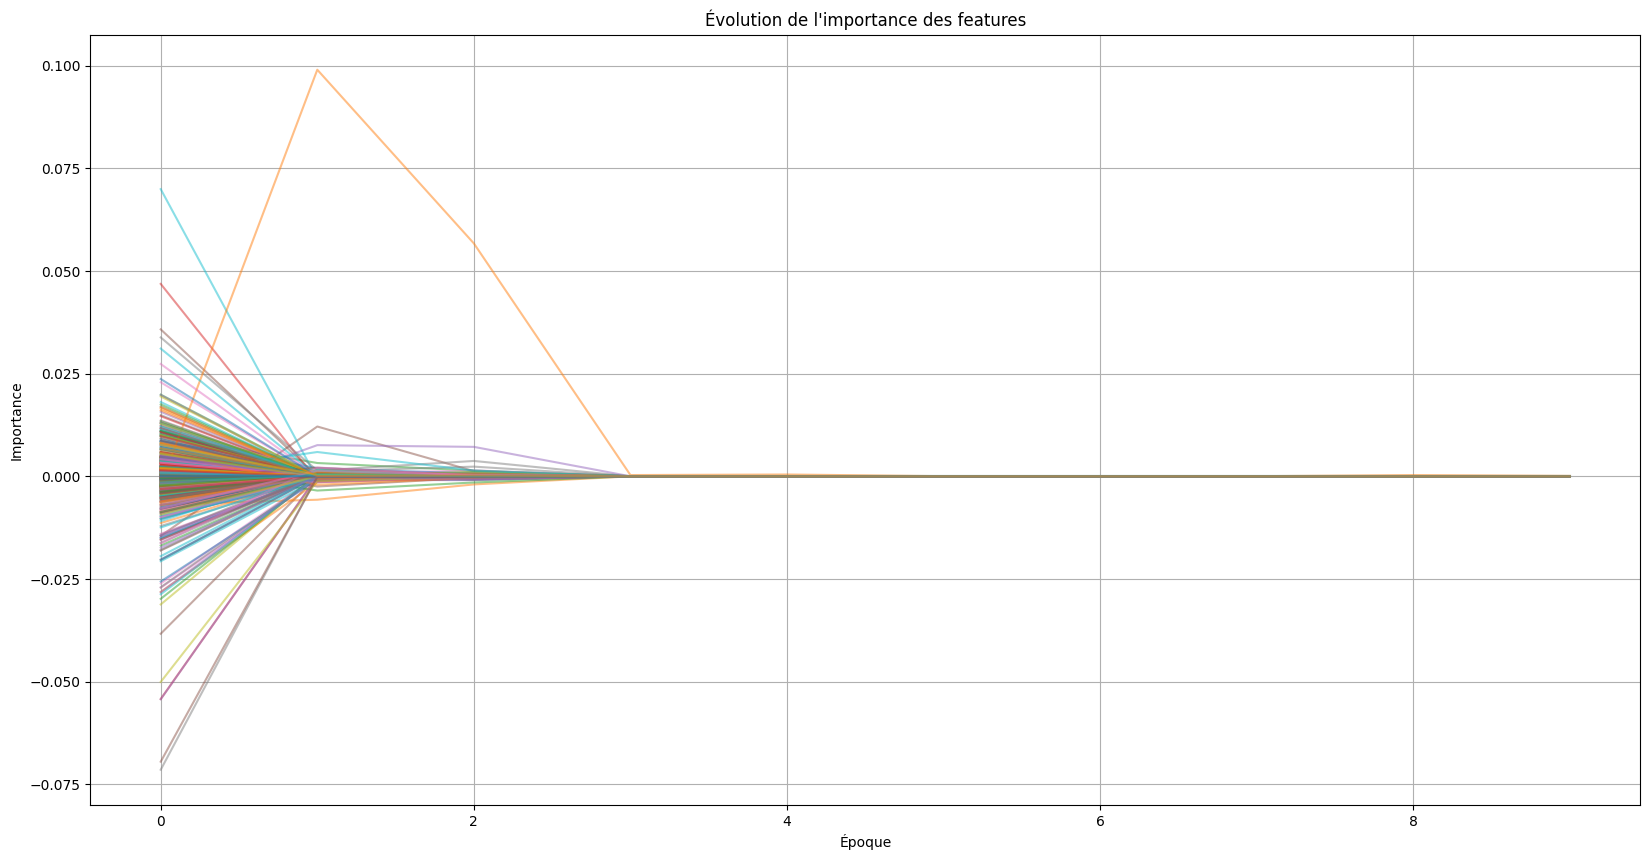

In [9]:
# Visualisation finale
plt.figure(figsize=(20, 10))
importances_array = np.array(importances_history)

for feature_idx in range(512):
    feature_history = importances_array[:, feature_idx]
    plt.plot(range(n_epochs), feature_history, alpha=0.5)

plt.title("Évolution de l'importance des features")
plt.xlabel("Époque")
plt.ylabel("Importance")
plt.grid(True)
plt.savefig(f'{SAVE_DIR}/feature_evolution.png')
plt.show()

# Sauvegarder les résultats
np.save(f'{SAVE_DIR}/importances_history.npy', importances_array)